# Lecture 16:  Iterative methods and preconditioners 

## Previous part

- Arnoldi orthogonalization of Krylov subspaces
- Lanczos for the symmetric case
- Energy functional and conjugate gradient method
- Convergence analysis
- Non-symmetric case: idea of GMRES

## Now we will cover the following topics

- More iterative methods: MINRES, BiCG and BiCGStab 
- The concept of preconditioners

## What methods to use

- If a matrix is symmetric (Hermitian) positive definite, use CG method.
- If a matrix is symmetric but indefinite, we can use MINRES method (GMRES applied to a symmetric system)
- If a matrix is non-symmetric and not very big, use GMRES
- If a matrix is non-symmetric and we can store limited amount of vectors, use either: GMRES with restarts, or BiCGStab (the latter of the product with $A^{\top}$ is also available).

### More detailed flowchart from [this book](https://www.netlib.org/linalg/html_templates/Templates.html)
<img src="flowchart_iterative_methods.png">

## MINRES

The MINRES method is GMRES applied to a symmetric system. We minimize

$$\Vert A Q_j x_j - f \Vert_2 = \Vert Q_j \widehat{x}_j + h_{j, j-1} q_j \widehat{x}_j - f \Vert_2 = \Vert Q_{j+1} \widehat{H}_{j+1}  \widehat{x}_j - f \Vert_2 \rightarrow \min$$

which is equivalent to a linear least squares with an **almost tridiagonal** matrix

$$\Vert \widehat{H}_{j+1} x_{j} - \gamma e_0 \Vert_2 \rightarrow \min.$$

- In a similar fashion, we can derive short-term recurrences.

- A careful implementation of MINRES requires at most $5$ vectors to be stored.

## Difference between MINRES and CG

- MINRES minimizes $\Vert Ax_k - f \Vert_2$ over the Krylov subspace
- CG minimize $(Ax, x) - 2(f, x)$ over the Krylov subspace
- MINRES works for indefinite (i.e., non-positive definite) problems.

CG stores less vectors ($3$ instead of $5$). 

Now, let us talk about non-symmetric systems.

## Non-symmetric systems

- The main disadvantage of GMRES: we have to store all the vectors, so the memory cost grows with each step.  

- We can do  **restarts** (i.e. get a new residual and a new Krylov subspace): we find some approximate solution $x$ and now solve the linear system for the correction:

$$A(x + e) = f, \quad Ae = f - Ax,$$

and generate the new **Krylov subspace** from the residual vector. This spoils the convergence, as we will see from the demo.

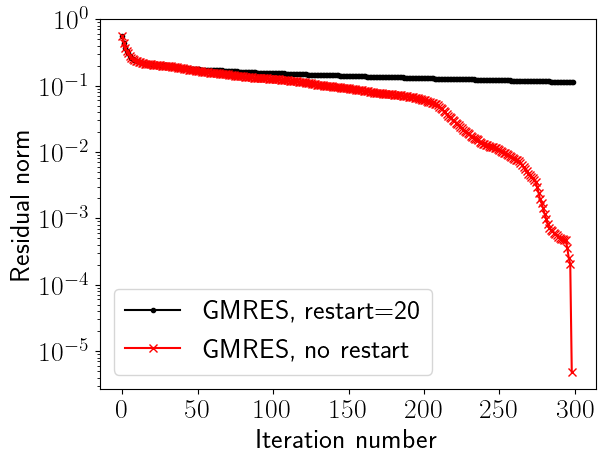

In [1]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
import numpy as np
import scipy as sp

n = 300
ex = np.ones(n);
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n)

res_gmres_rst = []
res_gmres = []
def gmres_rst_cl(r):
    res_gmres_rst.append(np.linalg.norm(r))
    
def gmres_rst(r):
    res_gmres.append(np.linalg.norm(r))

sol = scipy.sparse.linalg.gmres(A, rhs, restart=20, callback=gmres_rst_cl)
sol = scipy.sparse.linalg.gmres(A, rhs, restart=n, callback=gmres_rst)

lim = 300
plt.semilogy(res_gmres_rst[:lim], marker='.',color='k', label='GMRES, restart=20')
plt.semilogy(res_gmres[:lim], marker='x',color='r', label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

### How to avoid such spoiling of convergence?

- BiConjugate Gradient method (named **BiCG**, proposed by Fletcher, [original paper](https://link.springer.com/chapter/10.1007%2FBFb0080116)) avoids that using "short recurrences" like in the CG method.

## Idea of biconjugate gradient

Idea of BiCG method is to use the normal equations:

$$A^* A x = A^* f,$$

and apply the CG method to it.

- The condition number has squared, thus we need **stabilization**.

- The stabilization idea proposed by Van der Vorst et al. improves the stability (later in the lecture)

Let us do some demo for a simple non-symmetric matrix to demonstrate instability of BiCG method.

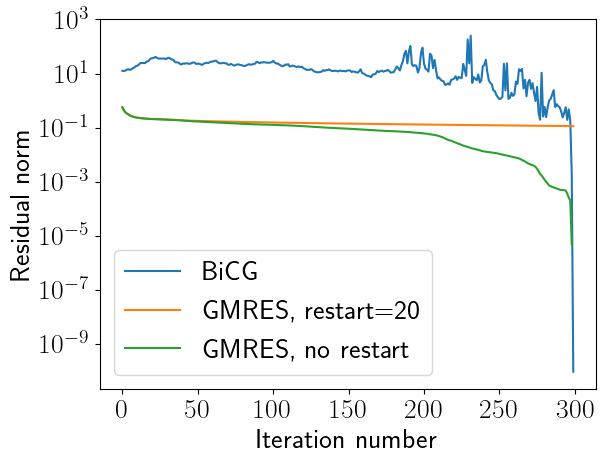

In [2]:
res_all_bicg = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))
    
sol = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(n), callback=bicg_cl)
plt.semilogy(res_all_bicg, label='BiCG')
plt.semilogy(res_gmres_rst[:n], label='GMRES, restart=20')
plt.semilogy(res_gmres, label='GMRES, no restart')
plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Residual norm', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

##  BiConjugate Gradients

There are two options:

1. Use $\mathcal{K}(A^* A, A^* f)$ to generate the subspace. That leads to square of condition number
2. Instead, use two Krylov subspaces $\mathcal{K}(A)$ and $\mathcal{K}(A^*)$ to generate two basises that are **biorthogonal** (so-called biorthogonal Lanczos).

The goal is to compute the Petrov-Galerkin projection 

$$W^* A V \widehat{x} = W^* f$$

with columns $W$ from the Krylov subspace of $A^*$, $V$ from $A$ (cf. with CG case). 

That may lead to instabilities if we try to recompute the solutions in the efficient way. It is related to the **pivoting** (which we did not use in CG), and it is not naturally implemented here.

## Notes about BiCG

A practical implementation of BiCG uses **two-sided Lanczos process**: generating Krylov subspace for $A$ and $A^{\top}$

In partucular

1. $\alpha_j = \frac{(r_j, \hat{r}_j)}{(Ap_j, \hat{p}_j)}$
2. $x_{j+1} = x_j + \alpha_j p_j $
3. $r_{j+1} = r_j - \alpha_j Ap_j$
4. $\hat{r}_{j+1} = \hat{r}_j - \alpha_j A^{\top}\hat{p}_j$
5. $\beta_j = \frac{(r_{j+1}, \hat{r}_{j+1})}{(r_j, \hat{r}_j)}$
6. $p_{j+1} = r_{j+1} + \beta_j p_j$
7. $\hat{p}_{j+1} = \hat{r}_{j+1} - \beta_j \hat{p}_j$

Now we move to the stable version of the BiCG method

## BiCGStab

- BiCGStab is frequently used, and represent a **stabilized** version of BiCG. It has faster and smoother convergence than original BiCG method.

- The formulas can be found, for example, [here](https://en.wikipedia.org/wiki/Biconjugate_gradient_stabilized_method)

- It is a combination of BiCG step followed by GMRES(1) step in order to smooth the convergence.

- For more details, please consult the book ["Iterative Krylov Methods for Large Linear Systems"](http://www.lmn.pub.ro/~daniel/ElectromagneticModelingDoctoral/Books/Numerical%20Methods/VanDerVorst2003%20Iterative%20Krylov%20Methods%20for%20Large%20Linear%20Systems.pdf) by H. Van-der Vorst.

A short demo to compare "Stabilized" vs "Non-stabilized" versions.

Dimension of the linear system = 600


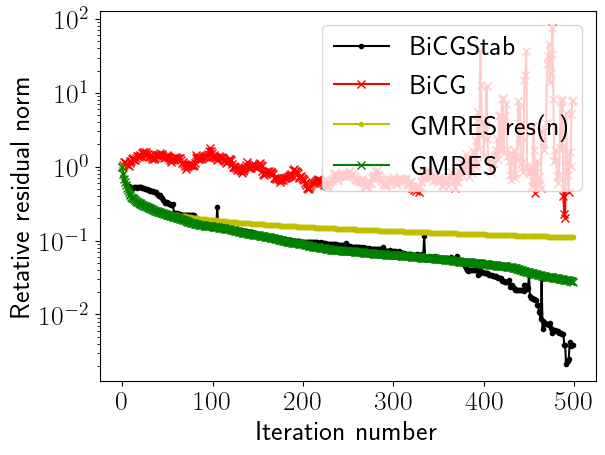

In [9]:
import scipy.sparse.linalg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

n = 600

ex = np.ones(n);
A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr') 
rhs = np.random.randn(n)

# ee = sp.sparse.eye(n)
# A = -sp.sparse.spdiags(np.vstack((ex,  -(2 + 1./n)*ex, (1 + 1./n) * ex)), [-1, 0, 1], n, n, 'csr')
# A = sp.sparse.kron(A, ee) + sp.sparse.kron(ee, A)
# rhs = np.ones(n * n)

print("Dimension of the linear system = {}".format(A.shape[0]))

res_all_bicg = []
res_all_bicgstab = []
def bicg_cl(x):
    res_all_bicg.append(np.linalg.norm(A.dot(x) - rhs))

def bicgstab_cl(x):
    res_all_bicgstab.append(np.linalg.norm(A.dot(x) - rhs))

res_gmres_rst = []
res_gmres = []
def gmres_rst_cl(r):
    res_gmres_rst.append(np.linalg.norm(r))
    
def gmres_rst(r):
    res_gmres.append(np.linalg.norm(r))

sol2 = scipy.sparse.linalg.gmres(A, rhs, restart=20, callback=gmres_rst_cl)
sol2 = scipy.sparse.linalg.gmres(A, rhs, restart=n, callback=gmres_rst)

    
sol2 = scipy.sparse.linalg.bicg(A, rhs, x0=np.zeros(A.shape[0]), callback=bicg_cl)
sol2 = scipy.sparse.linalg.bicgstab(A, rhs, x0=np.zeros(A.shape[0]), callback=bicgstab_cl)
res_all_bicg = np.array(res_all_bicg)/res_all_bicg[0]
res_all_bicgstab = np.array(res_all_bicgstab)/res_all_bicgstab[0]
res_gmres_rst = np.array(res_gmres_rst)/res_gmres_rst[0]
res_gmres = np.array(res_gmres)/res_gmres[0]

lim = 500
plt.semilogy(res_all_bicgstab[:lim], marker='.',color='k', label='BiCGStab')
plt.semilogy(res_all_bicg[:lim], marker='x',color='r', label='BiCG')
plt.semilogy(res_gmres_rst[:lim], marker='.',color='y', label='GMRES res(n)')
plt.semilogy(res_gmres[:lim], marker='x',color='g', label='GMRES')

plt.xlabel('Iteration number', fontsize=20)
plt.ylabel('Retative residual norm', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

## "Nonlinear GMRES" or Anderson acceleration

We can apply the GMRES-like idea to speed up the convergence of a given fixed-point iteration

$$x_{k+1} = \Phi(x_k).$$

This was actually older than the GMRES, and known as an Direct Inversion in Iterated Subspaces in Quantum Chemistry, or **Anderson Acceleration**.

Idea: **use history** for the update

$$x_{k+1} = \Phi(x_k) + \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})), $$

and the parameters $\alpha_s$ are selected to minimize the norm of the residual

$$ \min_{\alpha} \left \| \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})) \right\|_2, \quad \sum_{s=1}^m \alpha_s = 1$$

More details see in the original [paper](https://users.wpi.edu/~walker/Papers/Walker-Ni,SINUM,V49,1715-1735.pdf)

## Battling the condition number

- The condition number problem is **un-avoidable** if only the matrix-by-vector product is used.

- Thus we need an **army of preconditioners** to solve it.

- There are several **general purpose** preconditioners that we can use, but often for a particular problem a special design is needed.

## Preconditioner: general concept

The general concept of the preconditioner is simple:

Given a linear system 

$$A x = f,$$

we want to find the matrix $P_R$ and/or $P_L$ such that 

1. Condition number of $AP_R^{-1}$ (right preconditioner) or $P^{-1}_LA$ (right preconditioner) or $P^{-1}_L A P_R^{-1}$ is better than for $A$
2. We can easily solve $P_Ly = g$ or $P_Ry = g$ for any $g$ (otherwise we could choose e.g. $P_L = A$)

Then we solve for (right preconditioner)

$$ AP_R^{-1} y = f \quad \Rightarrow \quad P_R x = y$$ 

or  (left preconditioner)

$$ P_L^{-1} A x = P_L^{-1}f,$$ 
or even both
$$ P_L^{-1} A P_R^{-1} y = P_L^{-1}f \quad \Rightarrow \quad P_R x = y.$$ 

The best choice is of course $P = A,$ but this does not make life easier.

One of the ideas is to use other iterative methods (beside Krylov) as preconditioners.

## Other iterative methods as preconditioners
There are other iterative methods that we have not mentioned. 

1. Jacobi method
2. Gauss-Seidel
3. SOR($\omega$) (Successive over-relaxation) and its symmetric modification SSOR($\omega$)

## Jacobi method (as preconditioner)

Consider again the matrix with non-zero diagonal. To get the **Jacobi method** you express the diagonal element:

$$a_{ii} x_i = -\sum_{i \ne j} a_{ij} x_j + f_i$$

and use this to iteratively update $x_i$:

$$ x_i^{(k+1)} = -\frac{1}{a_{ii}}\left( \sum_{i \ne j} a_{ij} x_j^{(k)} + f_i \right),$$

or in the matrix form

$$
x^{(k+1)} = D^{-1}\left((D-A)x^{(k)} + f\right) 
$$

where $D = \mathrm{diag}(A)$ and finally

$$
x^{(k+1)} = x^{(k)} - D^{-1}(Ax^{(k)} - f).
$$

So, Jacobi method is nothing, but simple Richardson iteration with $\tau=1$ and left preconditioner $P = D$ - diagonal of a matrix. Therefore we will refer to $P = \mathrm{diag}(A)$ as **Jacobi preconditioner**. Note that it can be used for any other method like Chebyshev or Krylov-type methods.

## Properties of the Jacobi preconditioner

Jacobi preconditioner:

1. Very easy to compute and apply
2. Works well for diagonally dominant matrices (remember the Gershgorin circle theorem!)
3. Useless if all diagonal entries are the same (proportional to the identity matrix)

## Gauss-Seidel (as preconditioner)
Another well-known method is **Gauss-Seidel method**. 

Its canonical form is very similar to the Jacobi method, with a small difference. When we update $x_i$ as

$$x_i^{(k+1)} := -\frac{1}{a_{ii}}\left( \sum_{j =1}^{i-1} a_{ij} x_j^{(k+1)} +\sum_{j = i+1}^n a_{ij} x_j^{(k)} - f_i \right)$$

we **use it in the later updates**. In the Jacobi method we use the full vector from the previous iteration.

Its matrix form is more complicated.

## Gauss-Seidel: matrix version

Given $A = A^{*} > 0$ we have  

$$A = L + D + L^{*},$$

where $D$ is the diagonal of $A$, $L$ is lower-triangular part with zero on the diagonal.

One iteration of the GS method reads

$$
x^{(k+1)} = x^{(k)} - (L + D)^{-1}(Ax^{(k)} - f).
$$

and we refer to the preconditioner $P = L+D$ as **Gauss-Seidel preconditioner**.

**Good news:** $\rho(I - (L+D)^{-1} A) < 1, $ where $\rho$ is the spectral radius,

i.e. for a positive definite matrix GS-method always converges.

## Gauss-Seidel and coordinate descent

GS-method can be viewed as a coordinate descent method, applied to the energy functional

$$F(x) = (Ax, x) - 2(f, x)$$

with the iteration 

$$x_i := \arg \min_z F(x_1, \ldots, x_{i-1}, z, x_{i+1}, \ldots, x_d).$$

Moreover, the order in which we eliminate variables, is really important!

## Side note: Nonlinear Gauss-Seidel (a.k.a coordinate descent)
If $F$ is given, and we optimize one coordinate at a time, we have


$$x_i := \arg \min_z F(x_1, \ldots, x_{i-1}, z, x_{i+1}, \ldots, x_d).$$

**Note** the convergence result for block coordinate descent for the case of a general functional $F$: 

it converges locally with the speed of the GS-method applied to the **Hessian** $$H = \nabla^2 F$$ of the functional.

Thus, if $F$ is twice differentiable and $x_*$ is the local minimum, then $H > 0$ can Gauss-Seidel converges.

## Successive overrelaxation (as preconditioner)

We can even introduce a parameter $\omega$ into the GS-method preconditioner, giving a **successive over-relaxation** (**SOR($\omega$)**) method:

$$
x^{(k+1)} = x^{(k)} - \omega (D + \omega L)^{-1}(Ax^{(k)} - f).
$$

$$P = \frac{1}{\omega}(D+\omega L).$$

- Converges for $0<\omega < 2$. 
- Optimal selection of $\omega$ is **not trivial**. If the Jacobi method converges, then 
$$\omega^* = \frac{2}{1 + \sqrt{1 - \rho_J^2}},$$ 
where $\rho_J$ is spectral radius of Jacobi iterations
- Note that $\omega = 1$ gives us a Gauss-Seidel preconditioner.


## Preconditioners for sparse matrices

- If $A$ is sparse, one iteration of Jacobi, GS and SOR method is cheap (what complexity?). 

- For GS, we need to solve linear system with a sparse triangular matrix $L$, which costs $\mathcal{O}(nnz)$.

- For sparse matrices, however, there are more complicated algorithms, based on the idea of **approximate** LU-decomposition.

- Remember the motivation for CG: possibility of the early stopping, how to do approximate LU-decomposition for a sparse matrix? 

## Remember the Gaussian elimination

- Decompose the matrix $A$ in the form 

$$A = P_1 L U P^{\top}_2, $$

where $P_1$ and $P_2$ are certain **permutation** matrices (which do the pivoting).

- The most natural idea is to use **sparse** $L$ and $U$. 

- It is not possible without **fill-in** growth for example for matrices, coming from 2D/3D Partial Differential equations (PDEs).

- What to do?

## Incomplete LU

- Suppose you want to eliminate a variable $x_1$, and the equations have the form

$$5 x_1 + x_4 + x_{10} = 1, \quad 3 x_1 + x_4 + x_8 = 0, \ldots,$$

and in all other equations $x_1$ are not present. 

- After the elimination, only $x_{10}$ will enter additionally to the second equation (new fill-in).

$$x_4 + x_8 + 3(1 - x_4 - x_{10})/5 = 0$$

- In the Incomplete $LU$ case (actually, ILU(0)) we just throw away the **new fill-in**.

## Incomplete-LU: formal definition

We run the usual LU-decomposition cycle, but avoid inserting non-zeros **other** than the initial non-zero pattern. 

```python
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    for k in range(n): #Eliminate one row   
        L[k, k] = 1
        for i in range(k+1, n):
            L[i, k] = a[i, k] / a[k, k]
            for j in range(k+1, n):
                a[i, j] = a[i, j] - L[i, k] * a[k, j]  #New fill-ins appear here
        for j in range(k, n):
            U[k, j] = a[k, j]
```

## ILU(k)

- Yousef Saad (who is the author of GMRES) also had a [seminal paper](https://www-users.cs.umn.edu/~saad/PDF/umsi-92-38.pdf) on the **Incomplete LU** decomposition

- A good book on the topic is [Iterative methods for sparse linear systems](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf) by Y. Saad, 2003

- And he proposed **ILU(k)** method, which has a nice interpretation in terms of graphs.

## ILU(k): idea

- The idea of ILU(k) is very instructive and is based on the connection between sparse matrices and graphs.

- Suppose you have an $n \times n$ matrix $A$ and a corresponding adjacency graph.

- Then we eliminate one variable (vertex) and get a smaller system of size $(n-1) \times (n-1)$.

- New edges (=fill-in) appears between high-order neighbors.

## LU & graphs

- The new edge can appear only between vertices that had common neighbour: it means, that they are second-order neigbours.  
- This is also a sparsity pattern of the matrix $A^2.$
- The **ILU(k)** idea is to leave only the elements in $L$ and $U$ that are $k$-order neighbours in the original graph.

- The ILU(2) is very efficient, but for some reason completely abandoned (i.e. there is no implementation in MATLAB and SciPy).

- There is an original [Sparsekit](https://people.sc.fsu.edu/~jburkardt/f_src/sparsekit/sparsekit.html) software by Saad, which works quite well.

## ILU Thresholded (ILUT)
A much more popular approach is based on the so-called **thresholded LU**.

You do the standard Gaussian elimination with fill-ins, but either:

- Throw away elements that are smaller than threshold, and/or control the amount of non-zeros you are allowed to store.

- The smaller is the threshold, the better is the preconditioner, but more memory it takes.

It is denoted ILUT($\tau$).

## Symmetric positive definite case

- In the SPD case, instead of incomplete LU you should use Incomplete Cholesky, which is twice faster and consumes twice less memory.

- Both **ILUT** and **Ichol** are implemented in SciPy and you can try (nothing quite fancy, but it works).

## Second-order LU preconditioners

- There is a more efficient (but much less popular due to the limit of open-source implementations) **second-order** LU factorization [proposed by I. Kaporin](http://www.researchgate.net/profile/I_Kaporin/publication/242940993_High_quality_preconditioning_of_a_general_symmetric_positive_definite_matrix_based_on_its_UTU__UTR__RTU-decomposition/links/53f72ad90cf2888a74976f54.pdf)

- The idea (for symmetric matrices) is to approximate the matrix in the form

$$A \approx U_2 U^{\top}_2 + U^{\top}_2 R_2 + R^{\top}_2 U_2,$$

which is just the expansion of the $UU^{\top}$ with respect to the perturbation of $U$. 

- $U_1$ and $U_2$ are upper-triangular and sparse, whereare $R_2$ is small with respect to the drop tolerance parameter.



## Summary of this part

- Jacobi, Gauss-Seidel, SSOR (as preconditioners)
- Incomplete LU, three flavours: ILU(k), ILUT, ILU2

## Next lecture

- Convolution operation
- Toeplitz and circulant matrices
- Fast Fourier Transform

# Questions?

In [41]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()